## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import keras
import itertools
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras.regularizers import l1
import matplotlib.pyplot as plt
from keras import optimizers
%matplotlib inline

Using TensorFlow backend.


In [2]:
(x_train, y_train),(x_test, y_test ) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 44s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio 
# Hint 3 : 增加 Batch-normalization 層
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128],Regu_rate=1e-4,drp_ratio=0.2):
    
    model = Sequential()
    model.add(Dense(units = input_shape[1] ,input_dim = input_shape[1], kernel_initializer = 'normal', activation = 'relu',name = 'input'))
    
    for i, n_units in enumerate(num_neurons):
        model.add(Dense(units=n_units, kernel_initializer='normal', activation='relu',name="hidden_layer"+str(i+1), kernel_regularizer=l1(Regu_rate)))  
        model.add(Dropout(drp_ratio))  
        model.add(BatchNormalization())         
    
    model.add(Dense(units=output_units,kernel_initializer='normal', activation='softmax',name='output'))

    return model


In [0]:
def plot_model_score(results):
    
    NUM_COLORS = len(results.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    plt.figure(figsize=(10,8))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label='train-'+cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label='valid-'+cond, color=color_bar[i])
    plt.title("Loss")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


    plt.figure(figsize=(10,8))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label='train-'+cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label='valid-'+cond, color=color_bar[i])
    plt.title("Accuracy")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [0]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [512,1024]
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8]
Dropout_EXP = [0.2,0.4]

In [8]:
results = {}

for regu_rate,drop_rate,batch_size in itertools.product(L1_EXP,Dropout_EXP,BATCH_SIZE):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape=x_train.shape,Regu_rate=regu_rate,drp_ratio=drop_rate)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = f'L1:{str(regu_rate)},DR: {str(drop_rate)},BS:{str(batch_size)}'
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)  

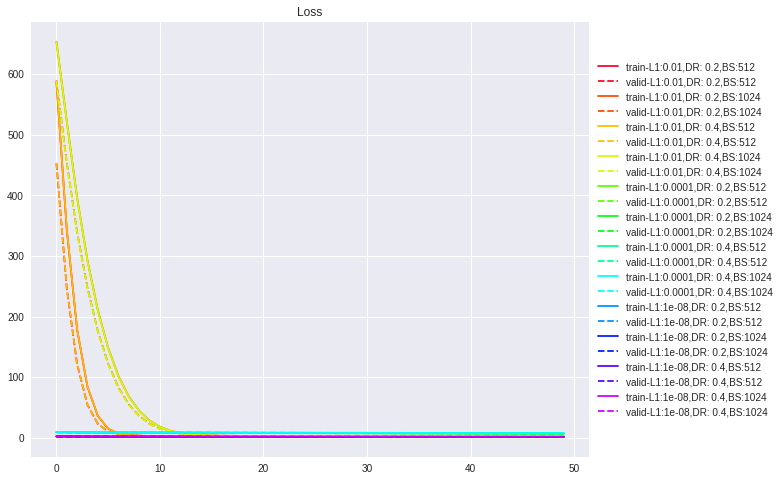

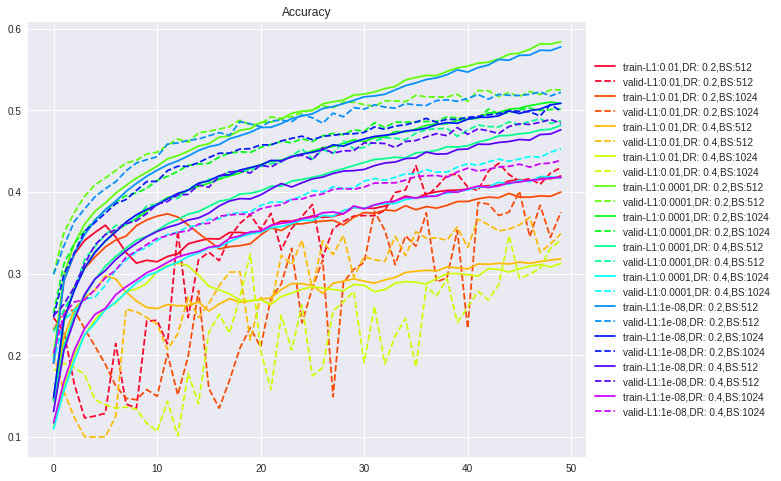

In [9]:
plot_model_score(results)